In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from scipy.stats import skew
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df = pd.read_csv("./data/subband_data.csv")
df = df.dropna()

In [5]:
data = df.to_numpy()
X = data[:,1:-1]
Y = data[:,-1]

#print(np.min(X))
assert(np.min(X) > 0)

X0 = X
X1 = np.log10(X0)
X0 = (X0-np.mean(X0, axis=0))/np.std(X0, axis=0)
X1 = (X1-np.mean(X1, axis=0))/np.std(X1, axis=0)

Nepochs, Nfeatures = X.shape
print(X.shape)

# reduce skew
X1_skew = skew(X1, axis=0)
X0_skew = skew(X0, axis=0)
skew_delta = np.abs(X0_skew)-np.abs(X1_skew)
skew_delta = skew_delta
#indices where we have non-beneficial log transform
bad_log_i = np.where(skew_delta < 0)
print(bad_log_i)

# ignore log transform
# X1 = X0

# # plot effect of log transform
# plt.figure()
# plt.scatter(np.arange(Nfeatures), skew_delta)
# plt.axhline(0, c="black", linestyle="--")
# plt.title("Skewness improvement with log transform")
# plt.show()

# i = np.argmax(np.abs(X1_skew))
# plt.figure()
# _ = plt.hist(X1[:,i], bins=100, label="Log transform")
# _ = plt.hist(X0[:,i], bins=100, label="Original")
# plt.legend()
# plt.title(f"Histogram of worst skewness after log transform - X{i}")
# plt.show()

# i = np.argmin(np.abs(X1_skew))
# plt.figure()
# _ = plt.hist(X1[:,i], bins=100, label="Log transform")
# _ = plt.hist(X0[:,i], bins=100, label="Original")
# plt.legend()
# plt.title(f"Histogram of best skewness after log transform - X{i}")
# plt.show()

# ignore log transform where it worsens skew
X1[:,bad_log_i] = X0[:,bad_log_i]
Y1 = Y

(97432, 22)
(array([12], dtype=int64),)


In [6]:
# split into training and testing
# with the training set, we want to rebalance using oversampling
Ntotal = X1.shape[0]
Ntrain = int(Ntotal*0.8)

idxs = np.arange(Ntotal)
np.random.shuffle(idxs)

Xtrain, Ytrain = X1[idxs[:Ntrain]], Y1[idxs[:Ntrain]]
Xtest, Ytest = X1[idxs[Ntrain:]], Y1[idxs[Ntrain:]]

#over_sampler = SMOTE()
#Xtrain, Ytrain = over_sampler.fit_resample(Xtrain, Ytrain)

print(Xtrain.shape)

Xtrain, Ytrain = torch.tensor(Xtrain.astype(np.float32)), torch.tensor(Ytrain.astype(np.int64))
Xtest,  Ytest  = torch.tensor(Xtest.astype(np.float32)),  torch.tensor(Ytest.astype(np.int64))

train_ds = TensorDataset(Xtrain, Ytrain)
test_ds = TensorDataset(Xtest, Ytest)

(77945, 22)


In [7]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, y_pred, y_true):
        L = self.loss(y_pred, y_true)
        return L
    
    def forward_no_seq(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

def get_accuracy(y_pred, y_true):
    y_pred_cls = y_pred.argmax(dim=-1)
    acc = (y_pred_cls == y_true).float()
    return acc.mean()

In [17]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, hidden_activ=torch.relu):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.hidden_activ = hidden_activ
        
        shapes = [self.n_inputs, *self.n_hidden, self.n_outputs]
        self.fc_models = []
        for dim_in, dim_out in zip(shapes[:-1], shapes[1:]):
            fc = nn.Linear(dim_in, dim_out)
            self.fc_models.append(fc)
        
        self.fc_models = nn.ModuleList(self.fc_models)
    
    # Takes in an input of size (B,F)
    # B = batch size
    # F = total features
    def forward(self, x):
        y = x
        for fc in self.fc_models:
            y = fc(y)
        return y

In [18]:
def train(model, optimiser, loss_func, train_dl, test_dl, total_epochs):
    model.train()
    for epoch in range(total_epochs):
        metrics = []
        for x, y_true in train_dl:
            optimiser.zero_grad()
            y_pred = model.forward(x)
            loss = loss_func.forward(y_pred, y_true)
            #loss = loss_func.forward_no_seq(y_pred, y_true)
            loss.backward()
            optimiser.step()

            acc = get_accuracy(y_pred, y_true)

            metrics.append(np.array([loss.detach().numpy(), acc.detach().numpy()]))
            print(f"\repoch={epoch:3d}, loss={loss:.4e}, acc={acc:.3f}", end="")
            
        metrics = np.array(metrics)
        train_loss, train_acc = np.mean(metrics, axis=0).flatten()
        test_loss, test_acc = test(model, loss_func, test_dl)
        print(f"\repoch={epoch:3d}, "+\
              f"loss={train_loss:.4e}, acc={train_acc:.3f}, "+\
              f"test_loss={test_loss:.4e}, test_acc={test_acc:.3f}")

In [19]:
def test(model, loss_func, test_dl):
    model.eval()
    metrics = []
    
    with torch.no_grad():
        for x, y_true in test_dl:
            y_pred = model.forward(x)
            loss = loss_func.forward(y_pred, y_true)
            acc = get_accuracy(y_pred, y_true)

            metrics.append(np.array([loss.detach().numpy(), acc.detach().numpy()]))
            #print(f"\repoch={epoch:3d}, loss={loss:.4e}, acc={acc:.3f}", end="")

    return np.mean(np.array(metrics), axis=0).flatten()

In [22]:
LEARNING_RATE = 0.001
BATCH_SIZE = 64
TOTAL_EPOCHS = 200

state_func = lambda x: F.softmax(x, dim=-1)
#state_func = torch.sigmoid

model = Model(n_inputs=Nfeatures, n_hidden=[100, 20], n_outputs=5, hidden_activ=nn.relu)

loss_func = Loss()
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimiser = optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [23]:
train(model, optimiser, loss_func, train_dl, test_dl, TOTAL_EPOCHS)

epoch=  0, loss=7.5590e-01, acc=0.716, test_loss=7.2723e-01, test_acc=0.728
epoch=  1, loss=7.1607e-01, acc=0.728, test_loss=7.0864e-01, test_acc=0.736
epoch=  2, loss=7.0538e-01, acc=0.733, test_loss=6.9989e-01, test_acc=0.738
epoch=  3, loss=6.9894e-01, acc=0.736, test_loss=7.0318e-01, test_acc=0.735
epoch=  4, loss=6.9586e-01, acc=0.738, test_loss=6.9336e-01, test_acc=0.738
epoch=  5, loss=6.9293e-01, acc=0.739, test_loss=7.0371e-01, test_acc=0.737
epoch=  6, loss=6.9163e-01, acc=0.740, test_loss=6.8693e-01, test_acc=0.743
epoch=  7, loss=6.9107e-01, acc=0.739, test_loss=7.0142e-01, test_acc=0.732
epoch=  8, loss=6.9153e-01, acc=0.740, test_loss=6.8534e-01, test_acc=0.744
epoch=  9, loss=6.9040e-01, acc=0.741, test_loss=6.8761e-01, test_acc=0.739
epoch= 10, loss=6.9027e-01, acc=0.740, test_loss=6.9718e-01, test_acc=0.734
epoch= 11, loss=6.8935e-01, acc=0.740, test_loss=6.8755e-01, test_acc=0.744
epoch= 12, loss=6.8839e-01, acc=0.741, test_loss=6.9265e-01, test_acc=0.735
epoch= 13, l

KeyboardInterrupt: 

0.8509316770186336
0.8509316770186336


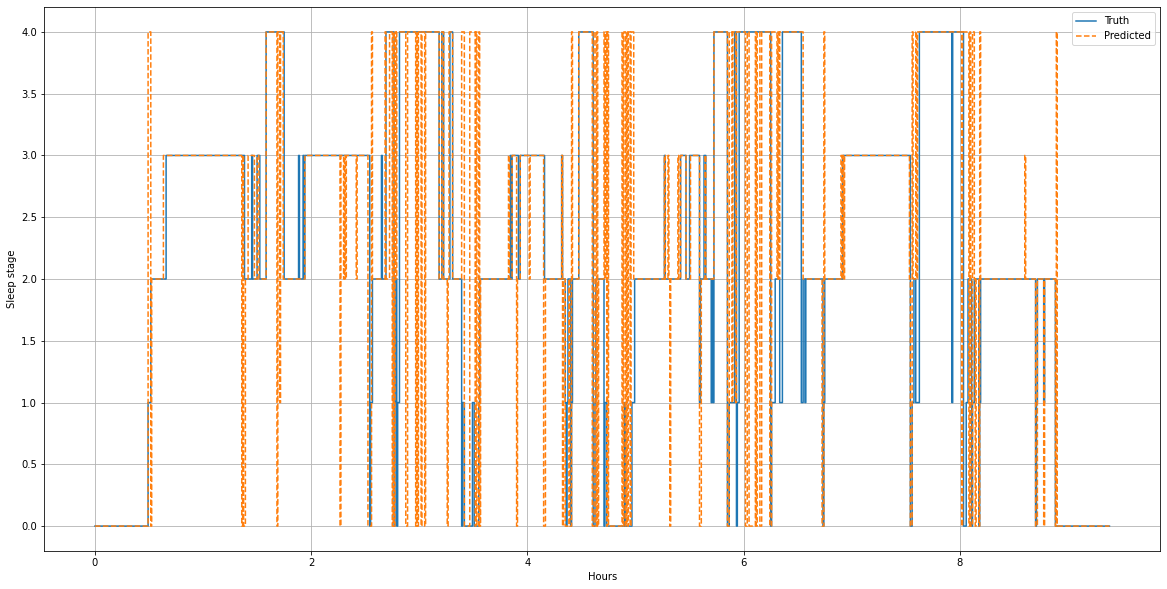

In [24]:
model.eval()

patient_mask = (df['pid'] == 0)
x = X1[patient_mask]
y = Y[patient_mask]

x = np.reshape(x, (1,*x.shape))

x = torch.Tensor(x.astype(np.float32))
y = torch.Tensor(y.astype(np.int64))

y_true = y
y_pred = model.forward(x)
y_pred = torch.argmax(y_pred, axis=-1)

y_true = y_true.detach().numpy().flatten()
y_pred = y_pred.detach().numpy().flatten()
x = x.squeeze(axis=0)

# Plot our true and predicted hypnogram
len_slice = 100
n_slice = 6
#i = np.arange(0, len_slice) + len_slice*n_slice
i = np.arange(0, y.shape[0])
epoch_time = 30
t = i*(epoch_time/3600) # hours
plt.figure(figsize=(20,10))
plt.step(t, y_true[i], label="Truth")
plt.step(t, y_pred[i], linestyle="--", label="Predicted")
plt.grid(True)
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Sleep stage")
print(np.mean(y_pred == y_true))
print(np.mean(y_true[i] == y_pred[i]))